# RQ2: Como o sentimento afeta o engajamento dos usuários, especialmente novatos?

In [1]:
import helper
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [2]:
# Get post + user data
post_data = helper.load_post_data('./data/analyzed.jsonl')
user_data = helper.load_user_data('./data/dump-users-last-interaction.json')

In [3]:
users_average_sentiment = helper.get_users_average_sentiment(post_data)

### Distribuição do sentimento médio dos usuários

Text(0.5, 1.0, 'Distribuição do sentimento médio dos usuários')

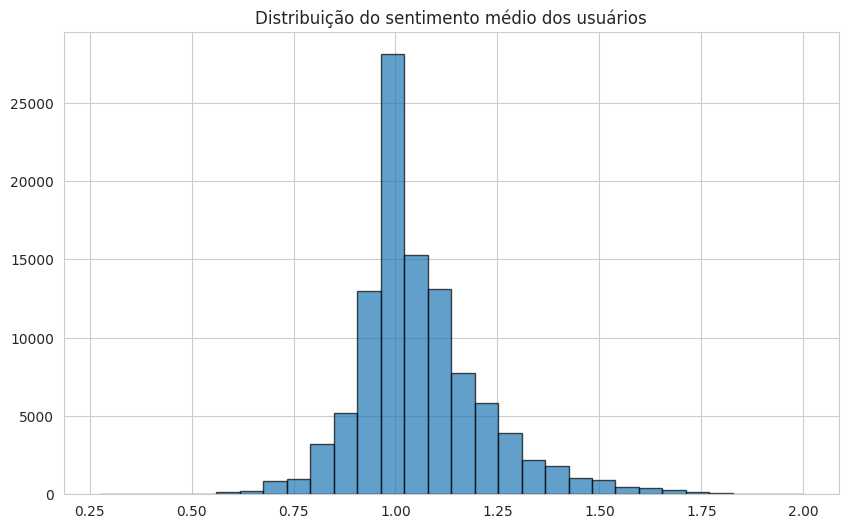

In [36]:
sentiment_values = [sentiment for user_id, sentiment in users_average_sentiment.items() if user_id is not None]

plt.figure(figsize=(10, 6))
plt.hist(sentiment_values, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribuição do sentimento médio dos usuários')

/tmp/ipykernel_183464/2042327201.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('Reputation_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])


Text(0, 0.5, 'Average Sentiment')

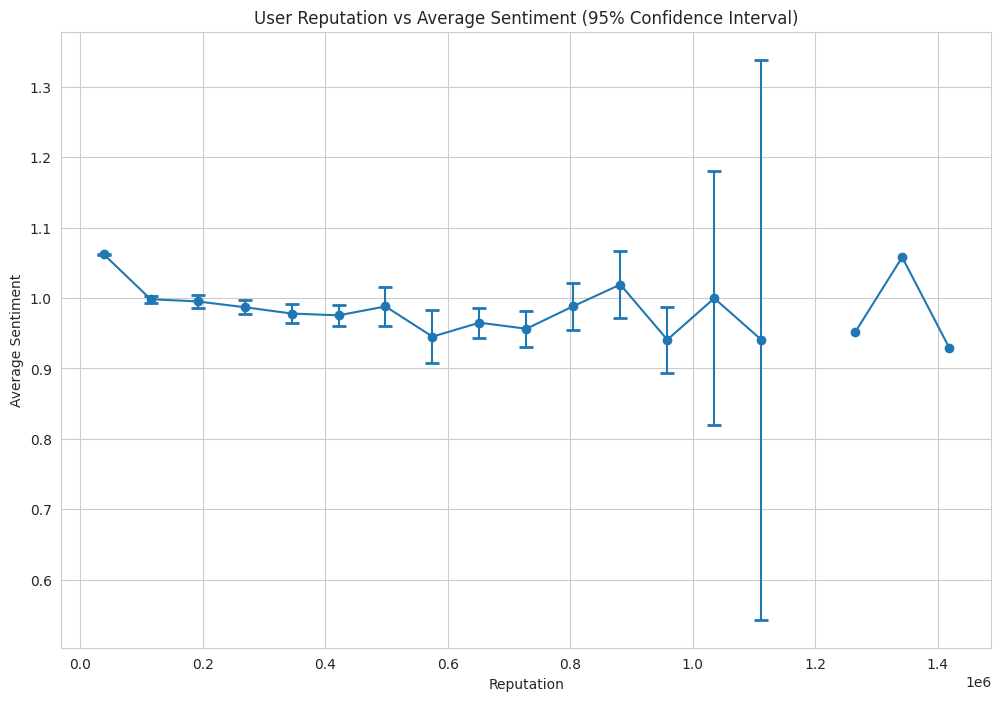

In [ ]:
user_reputation = {user_id: user['reputation'] for user_id, user in user_data.items() if user_id in users_average_sentiment and 'reputation' in user}

df = pd.DataFrame({
    'User ID': list(user_reputation.keys()),
    'Reputation': list(user_reputation.values()),
    'Average Sentiment': [users_average_sentiment[user_id] for user_id in user_reputation.keys()]
})

bins = np.linspace(df['Reputation'].min(), df['Reputation'].max(), 20)
df['Reputation_Binned'] = pd.cut(df['Reputation'], bins)
binned_stats = df.groupby('Reputation_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])

confidence_level = 0.95
alpha = 1 - confidence_level
bin_centers = [(interval.left + interval.right) / 2 for interval in binned_stats.index]

standard_errors = binned_stats['std'] / np.sqrt(binned_stats['count'])
degrees_freedom = binned_stats['count'] - 1
t_critical = [stats.t.ppf(1 - alpha/2, df) for df in degrees_freedom]
margin_of_error = standard_errors * t_critical

plt.figure(figsize=(12, 8))
plt.errorbar(bin_centers, binned_stats['mean'], yerr=margin_of_error, 
            fmt='o-', capsize=5, capthick=2, markersize=6)
plt.title('Reputação vs Sentimento médio dos usuários (intervalo de confiança de 95%)')
plt.xlabel('Reputação')
plt.ylabel('Sentimento médio')

/tmp/ipykernel_183464/2196032557.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('Period_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])


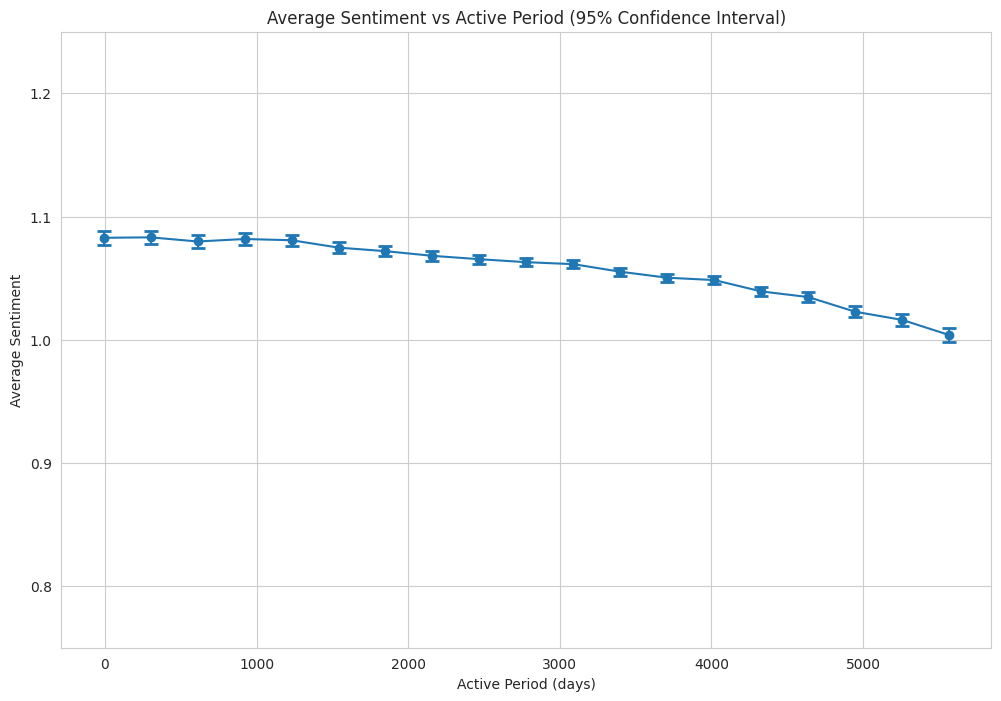

In [ ]:
user_active_period = {user_id: (user['last_interaction'] - user['creation_date']).days 
                      for user_id, user in user_data.items()}
df['Active Period (days)'] = [user_active_period[user_id] for user_id in df['User ID'] if user_id in user_active_period]

bins = np.linspace(df['Active Period (days)'].min(), df['Active Period (days)'].max(), 20)
df['Period_Binned'] = pd.cut(df['Active Period (days)'], bins)
binned_stats = df.groupby('Period_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])

confidence_level = 0.95
alpha = 1 - confidence_level
bin_centers = [(interval.left + interval.right) / 2 for interval in binned_stats.index]

standard_errors = binned_stats['std'] / np.sqrt(binned_stats['count'])
degrees_freedom = binned_stats['count'] - 1
t_critical = [stats.t.ppf(1 - alpha/2, df) for df in degrees_freedom]
margin_of_error = standard_errors * t_critical

plt.figure(figsize=(12, 8))
plt.errorbar(bin_centers, binned_stats['mean'], yerr=margin_of_error, 
            fmt='o-', capsize=5, capthick=2)
plt.title('Sentimento médio dos usuários por período ativo (intervalo de confiança de 95%)')
plt.xlabel('Período ativo (dias)')
plt.ylabel('Sentimento médio')
plt.ylim(0.75, 1.25)
plt.show()

## Como o **sentimento de um post** (pergunta ou resposta) afeta seu engajamento em termos dos comentários e do seu score?

TODO - acho que a distribuicao de scores/comentarios por sentimento apenas das respostas é diferente no das questões

ver tbm os sentimentos dos comentarios


In [7]:
parsed = {'scores': [[], [], []], 'num_comments': [[], [], []]}

def collect_post_data(post):
    sent = post['body_sentiment']

    parsed['scores'][sent].append(post['score'])
    parsed['num_comments'][sent].append(len(post['comments']))

    #Recursively add data
    if 'answers' in post:
        for a in post['answers']: collect_post_data(a)

#Run for prominent data
for id, post in post_data.items():
    collect_post_data(post)

Text(0.5, 1.0, 'Number of comments per post sentiment')

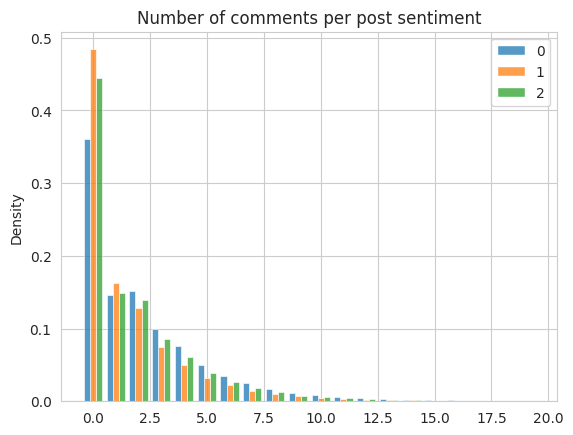

In [8]:
filter = [[x for x in l if x < 20] for l in parsed['num_comments']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Number of comments per post sentiment')

Text(0.5, 1.0, 'Score per post sentiment')

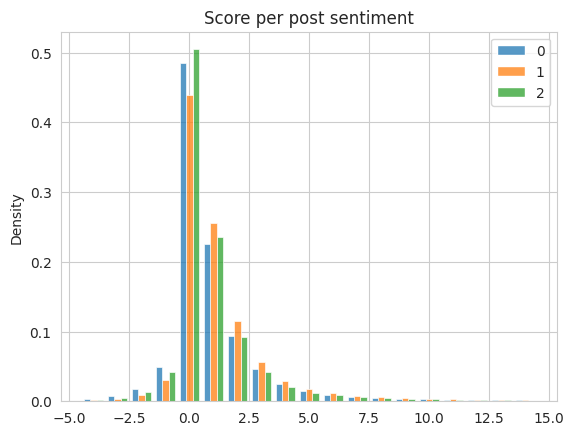

In [9]:
filter = [[x for x in l if -5 < x < 15] for l in parsed['scores']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Score per post sentiment')

## Analisando engajamento em torno do sentimento da **pergunta original**:

- [x] Número de respostas dado o sentimento da questão original -> A distribuição é a mesma
- [x] Score da pergunta dado o sentimento mínimo da pergunta -> Leve diferença (ver histograma)
- [x] Tempo de resposta mínimo dependendo do sentimento da questão original -> Leve diferença (ver boxplot)

In [10]:
ans = {'unanswered': [0,0,0], 'total': [0,0,0], 
       'response_times': [[], [], []], 'num_answers': [[], [], []], 
       'scores': [[], [], []], 'num_comments': [[],[],[]]}

for id, post in post_data.items():
    #Check question sentiment
    q_sent = post['body_sentiment']

    ans['total'][q_sent] += 1
    ans['num_answers'][q_sent].append(len(post['answers']))
    ans['scores'][q_sent].append(post['score'])

    ans['num_comments'][q_sent].append(len(post['comments']))
    
    if len(post['answers']) == 0: ans['unanswered'][q_sent] += 1
    else:
        quickest = (min([a['creation_date'] for a in post['answers']]) - post['creation_date'])
        ans['response_times'][q_sent].append(quickest.seconds / 3600)

In [11]:
print('Number of question for each answer:', ans['total'])

print('Number of unanswered question per question sentiment:')

for u,t in zip(ans['unanswered'], ans['total']):
    print(u / t)

print('Metric: Amount of anwers per question sentiment')
print('Mean', [float(np.mean(a)) for a in ans['num_answers']])
print('Standard deviation:', [float(np.std(a)) for a in ans['num_answers']])

print('\nMetric: Question score per question sentiment')
print('Mean:', [float(np.mean(a)) for a in ans['scores']])
print('Standard deviation:', [float(np.std(a)) for a in ans['scores']])

print('\nMetric: Response time per question sentiment')
print('Mean:', [float(np.mean(a)) for a in ans['response_times']])
print('Standard deviation:', [float(np.std(a)) for a in ans['response_times']])

Number of question for each answer: [120803, 720892, 158305]
Number of unanswered question per question sentiment:
0.14792678989760188
0.14028176203925138
0.14839076466315024
Metric: Amount of anwers per question sentiment
Mean [1.3536998253354635, 1.339779051508409, 1.299655727867092]
Standard deviation: [1.2015125090161722, 1.1515028855277245, 1.039488274165542]

Metric: Question score per question sentiment
Mean: [1.3843613155302434, 1.4315445309422217, 0.9691481633555479]
Standard deviation: [9.173996349083579, 10.303536846208223, 4.865474532057022]

Metric: Response time per question sentiment
Mean: [3.7243113130763588, 3.9938617876231026, 4.071148335237191]
Standard deviation: [6.14632485563535, 6.278911002127294, 6.3315843155574125]


<Axes: >

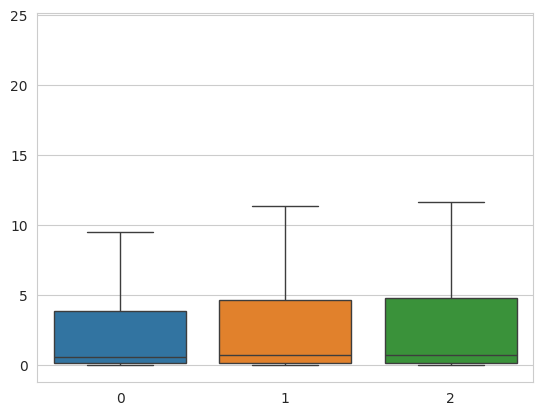

In [12]:
sns.boxplot(ans['response_times'], fliersize=False)

Text(0.5, 1.0, 'Question score per sentiment')

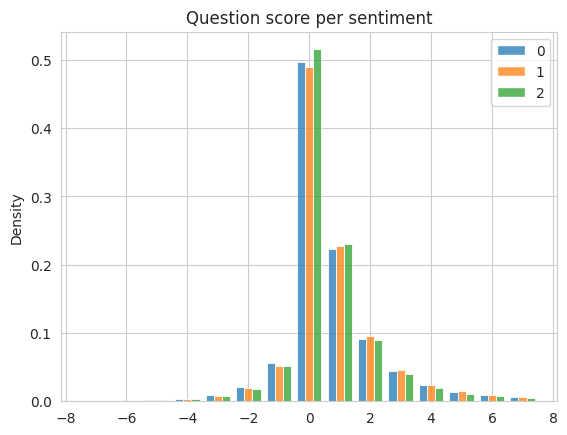

In [13]:
filter = [[x for x in l if -8 < x < 8] for l in ans['scores']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Question score per sentiment')

Text(0.5, 1.0, 'Number of comments per question sentiment')

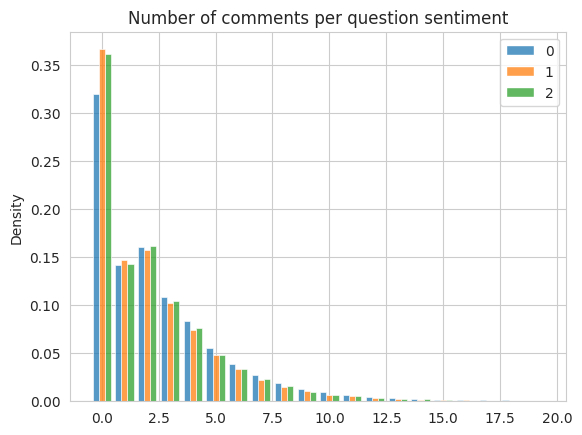

In [14]:
filter = [[x for x in l if x < 20] for l in ans['num_comments']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Number of comments per question sentiment')

In [15]:
abandon_limit = pd.to_datetime('2022-11-29', utc=True)

In [16]:
user_to_post = helper.get_user_to_interaction_posts_dict(post_data)

## Análise de duração de engajamento

Também analisar para sentimento do usuário, além de só o feedback dos outros

Esse aqui tá contando qualquer interação. Pegar só os posts que os usuários fizeram.

In [ ]:
def get_feedback_sentiment(post_id, post_owner_id):
    """
    Calculates the average sentiment of feedback (comments and answers) on a specific post,
    excluding any comments made by the post's original author.
    """
    if post_id not in post_data:
        return None

    post = post_data[post_id]
    feedback_sentiments = []

    for comment in post.get('comments', []):
        if comment.get('user_id') != post_owner_id:
            feedback_sentiments.append(comment['text_sentiment'])

    for answer in post.get('answers', []):
        if answer.get('owner_user_id') != post_owner_id:
            feedback_sentiments.append(answer['body_sentiment'])
        
        for comment in answer.get('comments', []):
            if comment.get('user_id') != post_owner_id:
                feedback_sentiments.append(comment['text_sentiment'])

    if not feedback_sentiments:
        return None
    
    return np.mean(feedback_sentiments)

def get_category_from_sentiment(sentiment):
    """
    Categorizes the sentiment into Positive, Neutral, or Negative.
    """
    if sentiment > 0.1:
        return 'Positive'
    elif sentiment < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:

# Escolha a tag para analisar. Use None para analisar todas as tags.
selected_tag = None


In [ ]:
user_engagement_data = []

for user_id, user_info in user_data.items():
    if user_id not in user_to_post:
        continue

    if user_info['last_interaction'] > abandon_limit:
        continue

    posts = user_to_post[user_id]

    # If a specific tag is selected, filter users based on their first posts tags
    if selected_tag is not None:
        user_has_tag = False
        for post_id, _ in posts:
            if post_id in post_data and selected_tag not in post_data[post_id]['tags']:
                continue

    # Get the average sentiment of feedback on the posts
    all_feedback_scores = []
    for post_id, post_date in posts:
        feedback_score = get_feedback_sentiment(post_id, user_id)
        if feedback_score is not None:
            all_feedback_scores.append(feedback_score)

    # If there was no feedback on any of the initial posts, skip the user
    if not all_feedback_scores:
        continue
    
    # Calculate the average feedback score across the first posts
    initial_feedback_score = np.mean(all_feedback_scores)

    # Calculate engagement duration in days
    engagement_duration = (user_info['last_interaction'] - user_info['creation_date']).days

    user_engagement_data.append({
        'user_id': user_id,
        'engagement_duration_days': engagement_duration,
        'sentiment_category': get_category_from_sentiment(users_average_sentiment[user_id]),
        'sentiment_score': users_average_sentiment[user_id],
        'feedback_category': get_category_from_sentiment(initial_feedback_score),
        'feedback_score': initial_feedback_score
    })

engagement_df = pd.DataFrame(user_engagement_data)

print(engagement_df['feedback_category'].value_counts())

feedback_category
Neutral     394952
Positive    119104
Negative     55278
Name: count, dtype: int64


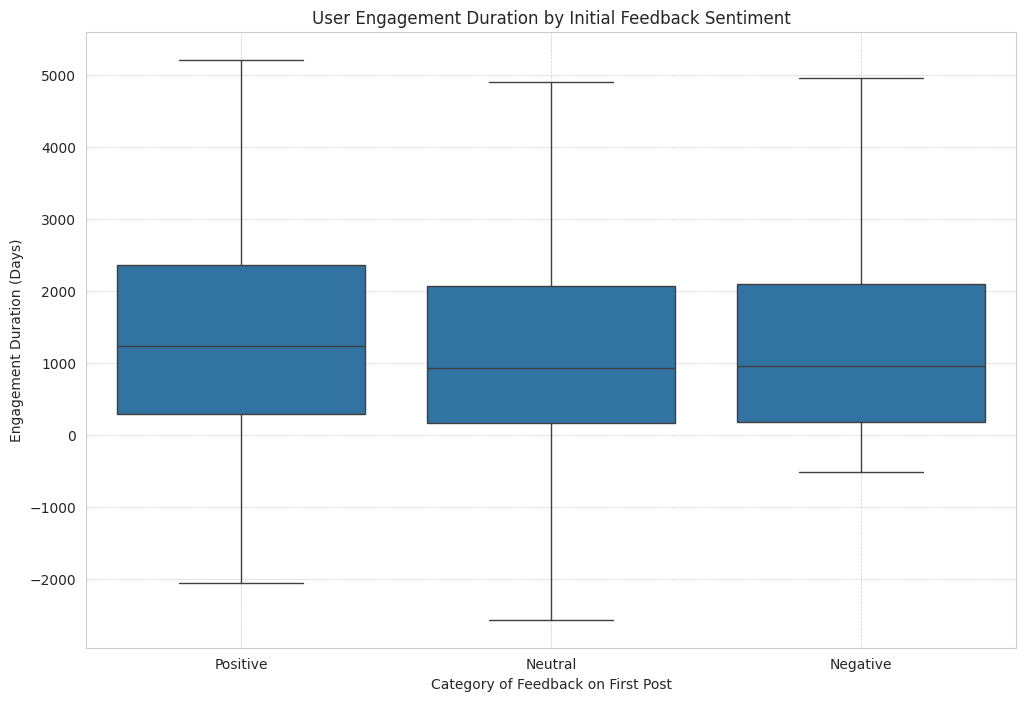

ANOVA Test Results:
F-statistic: 1389.0211
P-value: 0.0000

The difference in engagement duration between the groups is statistically significant.
This suggests that the sentiment of initial feedback is associated with how long a user remains active.


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='feedback_category', y='engagement_duration_days', 
            data=engagement_df, order=['Positive', 'Neutral', 'Negative'],
            showfliers=False)

plt.title('User Engagement Duration by Initial Feedback Sentiment')
plt.ylabel('Engagement Duration (Days)')
plt.xlabel('Category of Feedback on First Post')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

positive_engagement = engagement_df[engagement_df['feedback_category'] == 'Positive']['engagement_duration_days']
neutral_engagement = engagement_df[engagement_df['feedback_category'] == 'Neutral']['engagement_duration_days']
negative_engagement = engagement_df[engagement_df['feedback_category'] == 'Negative']['engagement_duration_days']

f_stat, p_value = stats.f_oneway(positive_engagement, neutral_engagement, negative_engagement)

if p_value < 0.05:
    print(f"\nStatistically significant: p = {p_value}")
else:
    print(f"\nNot statistically significant: p = {p_value}")

## Análise de early quitters

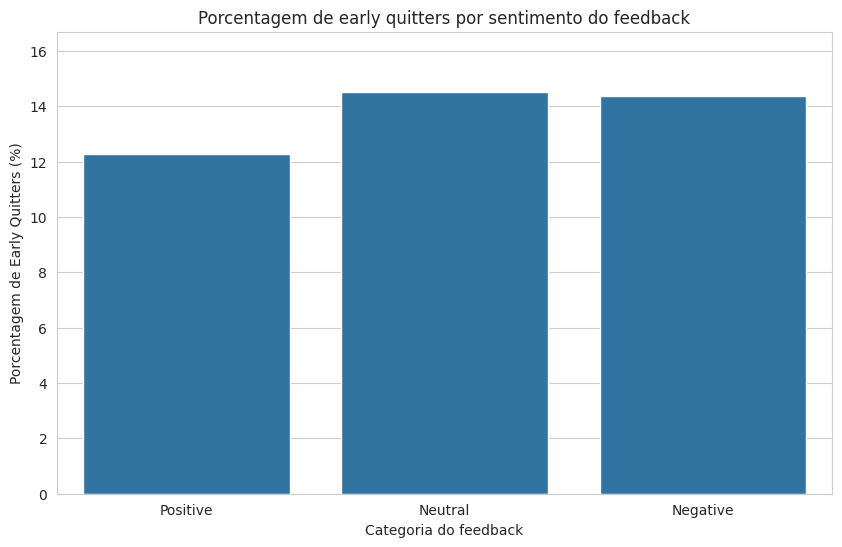


Estatisticamente significante: p =  4.971912999996859e-84


In [35]:
engagement_df['is_early_quitter'] = engagement_df['engagement_duration_days'] < 14

early_quitter_rates = engagement_df.groupby('feedback_category')['is_early_quitter'].mean() * 100
early_quitter_rates = early_quitter_rates.reindex(['Positive', 'Neutral', 'Negative'])

plt.figure(figsize=(10, 6))
sns.barplot(x=early_quitter_rates.index, y=early_quitter_rates.values)
plt.title('Porcentagem de early quitters por sentimento do feedback')
plt.ylabel('Porcentagem de Early Quitters (%)')
plt.xlabel('Categoria do feedback')
plt.ylim(0, max(early_quitter_rates.values) * 1.15)
plt.show()

contingency_table = pd.crosstab(engagement_df['feedback_category'], engagement_df['is_early_quitter'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

if p_value < 0.05:
    print("\nEstatisticamente significante: p = ", p_value)
else:
    print("\nNão estatisticamente significante: p = ", p_value)